# TaxBlock demonstration

By Jake Kara 
Final project 
CSCI E-118
Intro. to Blockchain and Bitcoin
Fall 2018


# Load solidity contracts

The solidity contracts that comprise TaxBlock are in the folder taxblock_solidity/

This script compiles them all together and creates an interface which we can use to instantiate individual contracts.

The _test_contracts_ module calls in python wrappers from the taxblock/ folder, which contains helpful wrappers of some of the common ethereum functions we learned in class. This abstraction allows for a simpler notebook.

In [1]:
!pip install qrcode
import qrcode
from test_contracts import source, interface


Loading contract 'Named'
Loading contract 'Owned'
Loading contract 'Authorized'
Loading contract 'TaxAuthority'
Loading contract 'Taxed'
Loading contract 'Traded'
Loading contract 'Property'
Loading contract 'TaxBill'
Loading contract 'Authorized'
Loading contract 'Offer'

Compiling...
Success!


In [2]:
print ("There are %d accounts. Let's assign them:" % len(interface.w3.eth.accounts))

users = ["me","joe","bob","steve","bill","alice","jane","kathy","sarah","iris"]

universe = {
}

for i in range(len(users)):
    universe[users[i]] = interface.w3.eth.accounts[i]    

get_address = lambda x: universe[x]

def get_user(x): 
    
    for k in universe.keys():
        if universe[k] == x:
            return k
        
def get_universe():
    ret = []
    for user in universe.keys():
        user_addr = get_address(user)

        assert get_user(user_addr) == user
        is_default = ""
            
        balance = interface.w3.eth.getBalance(user_addr)
        ret.append({
            "name":user,
            "address":user_addr,
            "balance":balance
        })
        
    return ret

def print_universe():
    
    for user in get_universe():
        
        is_default = ""
        
        if user["address"] == interface.w3.eth.defaultAccount:
            is_default = "default: "

        print ("    %s %12s: %d" % 
               (user["address"][:12], is_default + user["name"], user["balance"]))


print_universe()


There are 10 accounts. Let's assign them:
    0x7E5F455209  default: me: 1000000000000000000000000
    0x2B5AD5c479          joe: 1000000000000000000000000
    0x6813Eb9362          bob: 1000000000000000000000000
    0x1efF47bc3a        steve: 1000000000000000000000000
    0xe1AB8145F7         bill: 1000000000000000000000000
    0xE57bFE9F44        alice: 1000000000000000000000000
    0xd41c057fd1         jane: 1000000000000000000000000
    0xF1F6619B38        kathy: 1000000000000000000000000
    0xF7Edc8FA1e        sarah: 1000000000000000000000000
    0x4CCeBa2d7D         iris: 1000000000000000000000000


# 1. Creating a tax authority

Anyone can create a tax authority by instantiating a TaxAuthority contract. We will call our town Bethel.

In [3]:
# Create a tax authority called bethel
bethel = interface.instance(
    name="TaxAuthority",
    constructor_args=["Bethel".encode()]
)

universe["bethel tax authority"] = bethel.address

In [4]:
get_address("bethel tax authority")

'0xF2E246BB76DF876Cef8b38ae84130F4F55De395b'

In [5]:
get_user(get_address("bethel tax authority"))

'bethel tax authority'

In [6]:
# Convert bytes to strings and drop the remaining null characters
bytes2str = lambda b: b.decode("utf-8").rstrip('\x00')

# Print an underlined string
def underline(msg, char="="):
    msg_len = len(msg)
    print (msg)
    print (char * msg_len)
    
def summarize(tax_auth):
    underline ("TaxBlock summary for the town of %s" 
               % bytes2str(tax_auth.functions.name().call()))
    
    print("* The contract address is %s" % tax_auth.address)    
    print("* The owner is %s" % get_user(tax_auth.functions.owner().call())) 
    print("* The tax for transferring properties is $%d per $1000 of assessed value." % (
        tax_auth.functions.transferTaxRate().call()
    ))
    print("* Properties cannot be sold for %d permille more than their assessed value." % (
        tax_auth.functions.auditThreshold().call()
    ))
    print("* %s has issued %d tax bills." % (
        bytes2str(tax_auth.functions.name().call()),
        tax_auth.functions.taxBillCount().call()
    ))
    
summarize(bethel)

TaxBlock summary for the town of Bethel
* The contract address is 0xF2E246BB76DF876Cef8b38ae84130F4F55De395b
* The owner is me
* The tax for transferring properties is $0 per $1000 of assessed value.
* Properties cannot be sold for 0 permille more than their assessed value.
* Bethel has issued 0 tax bills.


In [7]:
# Let's set the audit threshold and the transfer tax rate

# - The audit threshold is used to compute the maximum allowed sale price, 
#   based on the assessed value. It is in milles of assessed value
# - The transfer tax rate is the per mille amount charged on the sale price
#   of each transaction

bethel.functions.setAuditThreshold(500).transact()
bethel.functions.setTransferTaxRate(10).transact()
summarize(bethel)

TaxBlock summary for the town of Bethel
* The contract address is 0xF2E246BB76DF876Cef8b38ae84130F4F55De395b
* The owner is me
* The tax for transferring properties is $10 per $1000 of assessed value.
* Properties cannot be sold for 500 permille more than their assessed value.
* Bethel has issued 0 tax bills.



This is the un-forgable contract address of the Bethel tax authority


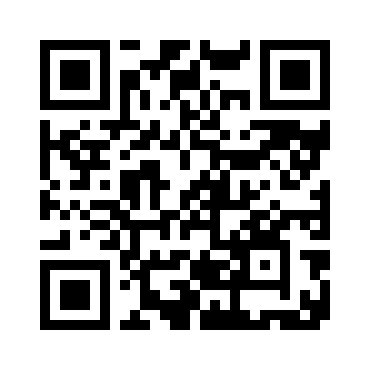

In [8]:
# Let's make a QR code we can share with property owners. 
# We can post it on the wall at town hall to make sure that
# they don't interact with fraudulent tax authorities.

def print_qr_code(tax_auth):
    print ("")
    print ("This is the un-forgable contract address of the %s tax authority"
          % bytes2str(tax_auth.functions.name().call()))
    return qrcode.make(tax_auth.address)

print_qr_code(bethel)

# 2. Creating properties

Now that we have set up the taxauthority contract and posted the QR code on the wall, we are ready for business in the town clerk's office.

When someone comes in, we need to be able to make a property for them that is controlled by our tax authority contract.

Oh look, Bob, who owns four properties on Greenwood Avenue, has walked in the door. After a quick check of his paper records, we can see that he's all paid up and we're ready to create his properties in the taxblock system.

In [9]:
# Now let's make some properties
def make_property(tax_auth, property_name):
    tax_auth.functions.createProperty(property_name.encode()).transact()

# Make the properties that bob owns.
make_property(bethel, "1 Greenwood Avenue")
make_property(bethel, "2 Greenwood Avenue")
make_property(bethel, "3 Greenwood Avenue")
make_property(bethel, "4 Greenwood Avenue")

In [10]:
# NOTE: We cannot create a duplicate named property. This IS SUPPOSED TO FAIL
try:
    make_property(bethel, "1 Greenwood Avenue")
except:
    print ("GOOD, THIS WAS SUPPOSED TO FAIL!")

GOOD, THIS WAS SUPPOSED TO FAIL!


In [11]:
# Get a property
def get_property(tax_auth, property_name):
    return interface.instance_at_address(
        name="Property",
        address=tax_auth.functions.getPropertyByName(
            property_name.encode()
        ).call()
)

greenwood_1 = get_property(bethel, "1 Greenwood Avenue")
greenwood_1

In [12]:
def who_owns(ownable):
    
    # Any ownable will have an owner() function, a 
    # public getter() of the owner contract attribute
    
    owner_address = ownable.functions.owner().call()
    try:
        return get_user(owner_address)
    except:
        pass
    return owner_address

who_owns(bethel)

'me'

In [13]:
# Check who owns 1 Greenwood Avenue
who_owns(greenwood_1)

'bethel tax authority'

In [14]:
# Let's use the event log to get a list of properties
def read_log_entries(entity, event_type):
    ret = entity.events[event_type].createFilter(fromBlock=0).get_all_entries()
    return ret

def get_all_properties(tax_auth):
    ret = read_log_entries(tax_auth, "NewProperty")
    return [bytes2str(x["args"]["propertyName"]) for x in ret]

get_all_properties(bethel)


['1 Greenwood Avenue',
 '2 Greenwood Avenue',
 '3 Greenwood Avenue',
 '4 Greenwood Avenue']

In [15]:
def who_owns_every_property(tax_auth):
    for addr in get_all_properties(tax_auth):
        print ("%s: %s" % (addr, who_owns(get_property(bethel, addr))))
        
who_owns_every_property(bethel)

1 Greenwood Avenue: bethel tax authority
2 Greenwood Avenue: bethel tax authority
3 Greenwood Avenue: bethel tax authority
4 Greenwood Avenue: bethel tax authority


In [16]:
# Ok, let's finally change the owner of one
def transfer_property(tax_auth, prop, new_owner_address):
    tax_auth.functions.transferProperty(
        prop.functions.name().call(),
        new_owner_address
    ).transact()
    
transfer_property(bethel,
                  get_property(bethel, "1 Greenwood Avenue"),
                  get_address("bob"))

who_owns_every_property(bethel)

1 Greenwood Avenue: bob
2 Greenwood Avenue: bethel tax authority
3 Greenwood Avenue: bethel tax authority
4 Greenwood Avenue: bethel tax authority


In [17]:
# Woohoo! Let's do the rest
bethel.functions.transferProperty("2 Greenwood Avenue".encode(),
                                 get_address("bob")).transact()
bethel.functions.transferProperty("3 Greenwood Avenue".encode(),
                                 get_address("bob")).transact()
bethel.functions.transferProperty("4 Greenwood Avenue".encode(),
                                 get_address("bob")).transact()
who_owns_every_property(bethel)

1 Greenwood Avenue: bob
2 Greenwood Avenue: bob
3 Greenwood Avenue: bob
4 Greenwood Avenue: bob


In [18]:
def reposses_property(tax_auth, prop):
    transfer_property(
        tax_auth, 
        prop, 
        tax_auth.address
    )
reposses_property(bethel, get_property(bethel, "1 Greenwood Avenue"))
who_owns_every_property(bethel)

1 Greenwood Avenue: bethel tax authority
2 Greenwood Avenue: bob
3 Greenwood Avenue: bob
4 Greenwood Avenue: bob


# Check if properties are paid up

In [19]:
greenwood_1.functions.billIndex().call()

0

In [20]:
bethel.functions.taxBillCount().call()

0

In [21]:
greenwood_1.functions.isPaidCurrent().call()

True

# 3. Issuing tax bills

In [22]:
def create_tax_bill(tax_auth, tax_rate):
    
    """ tax_rate must be a per-mille amount, per 1000, 
    instead of percent which is per 100 """
    
    tax_auth.functions.createTaxBill(tax_rate).transact()

create_tax_bill(bethel, 30)
bethel.functions.taxBillCount().call()

1

In [23]:
# See that a new tax bill event was created
read_log_entries(bethel, "NewTaxBill")

[AttributeDict({'args': AttributeDict({'taxBillIndex': 0}),
  'event': 'NewTaxBill',
  'logIndex': 0,
  'transactionIndex': 0,
  'transactionHash': HexBytes('0xe649782982bdbdaa0cef07d2fbcc9bd5316227414ffb99132c5b7e27be341bde'),
  'address': '0xF2E246BB76DF876Cef8b38ae84130F4F55De395b',
  'blockHash': HexBytes('0x1034ec5ba775a56d17e1606c6b7299e795c6ab3cdfcad344fef21bc13a22c5c2'),
  'blockNumber': 13})]

In [24]:
def get_tax_bill(tax_auth, i):
    return interface.instance_at_address(
        "TaxBill",
        tax_auth.functions.taxBills(i).call()
    )
tax_bill = get_tax_bill(bethel, 0)
print ("Property owes... %d " % tax_bill.functions.amountDue(greenwood_1.address).call())

Property owes... 0 


# 4. Paying taxes

Now that a tax bill has been issued, let's see if our properties are still paid current

In [25]:
# Is Greenwood 1 still paid current?
get_property(bethel, "1 Greenwood Avenue").functions.isPaidCurrent().call()

False

### Let's see how much the owner owes

In [26]:
def property_summary(tax_auth, property_name):
    
    prop = get_property(tax_auth, property_name)
    
    underline("Summary for %s in %s" % (
        property_name,
        bytes2str(tax_auth.functions.name().call()),
    ))
    
    assessed_value = prop.functions.assessedValue().call()
   
    print ("* Owner is %s" % who_owns(prop))
    print ("* Assessed value is %d" % assessed_value)
    print ("* The maximum sale price is %d" % 
           tax_auth.functions.maximumSalePrice(assessed_value).call())
    print ("* The tax authority has issued %d tax bills" % tax_auth.functions.taxBillCount().call())
    print ("* The property has paid %d tax bills" % prop.functions.billIndex().call())
    is_paid = "is not"
    
    if prop.functions.isPaidCurrent().call():
        is_paid = "is"
    else:
        print (
        "* Here's the next outstanding bill: %d" % 
               get_tax_bill(
                   tax_auth, 
               prop.functions.billIndex().call()
           ).functions.amountDue(prop.address).call()
          )

    print ("* The property %s paid current" % is_paid)
    
property_summary(bethel, "1 Greenwood Avenue")


Summary for 1 Greenwood Avenue in Bethel
* Owner is bethel tax authority
* Assessed value is 0
* The maximum sale price is 0
* The tax authority has issued 1 tax bills
* The property has paid 0 tax bills
* Here's the next outstanding bill: 0
* The property is not paid current


###  Nothing? That's because the property has no value...

Let's make it a $1 million property.

In [27]:
def set_assessed_value(tax_auth, prop, new_value):
    return tax_auth.functions.setPropertyAssessedValue(
        prop.address, 1000 * 1000
    ).transact() 

set_assessed_value(bethel,
                   greenwood_1,
                   1000 * 1000)


HexBytes('0x1233d71be121ca46a602f1087f8462ed998b84d2eb555ed94f17208a5c86a566')

... remember, tax rates are permille, not percent, so they are $30 per $1,000 in value, or:

In [28]:
#print ("Property owes... %d " % tax_bill.functions.amountDue(greenwood_1.address).call())
property_summary(bethel, "1 Greenwood Avenue")


Summary for 1 Greenwood Avenue in Bethel
* Owner is bethel tax authority
* Assessed value is 1000000
* The maximum sale price is 1500000
* The tax authority has issued 1 tax bills
* The property has paid 0 tax bills
* Here's the next outstanding bill: 30000
* The property is not paid current


In [29]:
# Pay the taxes

def pay_next_bill(tax_auth, prop):
    tax_auth.functions.payBill(prop.address).transact({
        "value":tax_bill.functions.amountDue(prop.address).call(),
    })
    
pay_next_bill(bethel, greenwood_1)

In [30]:
property_summary(bethel, "1 Greenwood Avenue")


Summary for 1 Greenwood Avenue in Bethel
* Owner is bethel tax authority
* Assessed value is 1000000
* The maximum sale price is 1500000
* The tax authority has issued 1 tax bills
* The property has paid 1 tax bills
* The property is paid current


In [31]:
# Hooray! The taxes are paid. Let's check the town records...
read_log_entries(bethel, "BillPaid")

[AttributeDict({'args': AttributeDict({'status': 2}),
  'event': 'BillPaid',
  'logIndex': 0,
  'transactionIndex': 0,
  'transactionHash': HexBytes('0xb10f1e6f9c781f30e5a9234ea30e63236edaa6e074d5e4d8ed3a65afcf122ff8'),
  'address': '0xF2E246BB76DF876Cef8b38ae84130F4F55De395b',
  'blockHash': HexBytes('0x652285bc2070cb81828b852d3c4c68b07999c46dae9feb73c55588fcaacc3243'),
  'blockNumber': 15})]

In [32]:
# Checking the town's total receipts
tax_bill.functions.totalReceipts().call()

30000

In [33]:
print_universe()

    0x7E5F455209  default: me: 999999999999999993693550
    0x2B5AD5c479          joe: 1000000000000000000000000
    0x6813Eb9362          bob: 1000000000000000000000000
    0x1efF47bc3a        steve: 1000000000000000000000000
    0xe1AB8145F7         bill: 1000000000000000000000000
    0xE57bFE9F44        alice: 1000000000000000000000000
    0xd41c057fd1         jane: 1000000000000000000000000
    0xF1F6619B38        kathy: 1000000000000000000000000
    0xF7Edc8FA1e        sarah: 1000000000000000000000000
    0x4CCeBa2d7D         iris: 1000000000000000000000000
    0xF2E246BB76 bethel tax authority: 30000


# 5. Making an offer

Remeber the rules:

1. A property with back taxes cannot be sold
2. A  property cannot be sold for a lot more than* its assessed value

"A lot more" is defined as:

property.assessedValue + (tax_authority.auditTreshold / 1000) * property.assessedValue

In [34]:
def get_address_balance(address):
    return interface.w3.eth.getBalance(address)

def get_entity_balance(entity):
    return get_address_balance(entity.address)

get_address_balance(get_address("me"))

999999999999999993693550

In [35]:
# First let's test that we can transfer a property
transfer_property(bethel, greenwood_1, get_address("joe"))
who_owns_every_property(bethel)

1 Greenwood Avenue: joe
2 Greenwood Avenue: bob
3 Greenwood Avenue: bob
4 Greenwood Avenue: bob


In [36]:
# Now let's make an offer. 
# Alice wants to buy 1 Greenwood Avenue for $1,000,001

def submit_offer(prop, amount, from_user):
    offer = interface.instance(
        name="Offer",
        constructor_args=[prop.address],
        transaction_params={
            "value": amount,
            "from":get_address(from_user)
        }
    )

    # Submit the offer
    greenwood_1.functions.makeOffer(
        offer.address
    ).transact({"from":get_address(from_user)})
    read_log_entries(greenwood_1, "NewOffer")
    
    return offer

offer = submit_offer(greenwood_1, 1 + 1000 * 1000, "alice")


In [37]:
# Let's make sure the offer is funded
interface.w3.eth.getBalance(offer.address)

1000001

# 6. Accepting an offer

In [38]:
# Let's see how much money joe has before we accept the transaction
interface.w3.eth.getBalance(get_address("joe"))

1000000000000000000000000

In [39]:
offer.functions.accept().transact({"from":get_address("joe")})

HexBytes('0x96bf1c092b9d9e5ec88087cee5e72e15ef424ffc74577b7588055ca7bc14d128')

In [40]:
interface.w3.eth.getBalance(get_address("joe"))

1000000000000000000924093

In [41]:
# Now let's see who owns it
who_owns(greenwood_1)

'alice'

In [42]:
print_universe()

    0x7E5F455209  default: me: 999999999999999993659683
    0x2B5AD5c479          joe: 1000000000000000000924093
    0x6813Eb9362          bob: 1000000000000000000000000
    0x1efF47bc3a        steve: 1000000000000000000000000
    0xe1AB8145F7         bill: 1000000000000000000000000
    0xE57bFE9F44        alice: 999999999999999997788543
    0xd41c057fd1         jane: 1000000000000000000000000
    0xF1F6619B38        kathy: 1000000000000000000000000
    0xF7Edc8FA1e        sarah: 1000000000000000000000000
    0x4CCeBa2d7D         iris: 1000000000000000000000000
    0xF2E246BB76 bethel tax authority: 40000


In [43]:
# Now let's try an invalid transaction. 
# jane will try to buy the property for 2 million
offer2 = submit_offer(greenwood_1, 1 + 2000 * 1000, "jane")
offer2.functions.accept().transact({"from":get_address("alice")})

HexBytes('0x5618cbd3152e7c8dafa533ad5dc6fbc13e7d29c1bf938e7952d610598b18ef39')

In [44]:
# We can see that the transaction failed and Alice still owns the property
who_owns(greenwood_1)

'alice'

In [45]:
property_summary(bethel, "1 Greenwood Avenue")

Summary for 1 Greenwood Avenue in Bethel
* Owner is alice
* Assessed value is 1000000
* The maximum sale price is 1500000
* The tax authority has issued 1 tax bills
* The property has paid 1 tax bills
* The property is paid current


In [46]:
# OK, Jane has decied to make a new offer
offer2 = submit_offer(greenwood_1, 1500 * 1000, "jane")
offer2.functions.accept().transact({"from":get_address("alice")})
property_summary(bethel, "1 Greenwood Avenue")

Summary for 1 Greenwood Avenue in Bethel
* Owner is jane
* Assessed value is 1000000
* The maximum sale price is 1500000
* The tax authority has issued 1 tax bills
* The property has paid 1 tax bills
* The property is paid current


In [47]:
who_owns_every_property(bethel)

1 Greenwood Avenue: jane
2 Greenwood Avenue: bob
3 Greenwood Avenue: bob
4 Greenwood Avenue: bob


In [48]:
print_universe()

    0x7E5F455209  default: me: 999999999999999993659683
    0x2B5AD5c479          joe: 1000000000000000000924093
    0x6813Eb9362          bob: 1000000000000000000000000
    0x1efF47bc3a        steve: 1000000000000000000000000
    0xe1AB8145F7         bill: 1000000000000000000000000
    0xE57bFE9F44        alice: 999999999999999999162541
    0xd41c057fd1         jane: 999999999999999994137151
    0xF1F6619B38        kathy: 1000000000000000000000000
    0xF7Edc8FA1e        sarah: 1000000000000000000000000
    0x4CCeBa2d7D         iris: 1000000000000000000000000
    0xF2E246BB76 bethel tax authority: 2055001
